To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week8/multi_class_classification.ipynb)


In [15]:
import numpy as np
import torch
from torch import nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# Previous Lecture (Multi-layer Feed Forward Neural Networks)

We can learn a feature representation by repetitively doing.
$$ 
 \mathbf{z}_\ell = \sigma(\mathbf{z}_{\ell-1}\mathbf{W}^\top_\ell ).
$$

```python
from torch import nn 
model = nn.Sequential(
    nn.Linear(1, 100), # first layer with 100 neurons
    nn.SiLU(), # activation function 
    nn.Linear(100, 100), # second layer with 100 neurons
    nn.SiLU(), # activation function 
    nn.Linear(100, 100), # third layer with 100 neurons
    nn.SiLU(), # second layer with 100 neurons
    nn.Linear(100, 1) # last layer
)
```

The dimensions of $\mathbf{W}^\top_\ell$ and the flavour of the activation function $\sigma(\cdot)$, are consider hyper-parameters; meaning, one have to test various configurations to search for the optimal architecture. \
**Bayesian optimization** have been used to accelerate the search of the optimal neural architecture, [link](https://medium.com/abacus-ai/an-introduction-to-bayesian-optimization-for-neural-architecture-search-d324830ec781).

**Diagram**\
<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/MLP_diagram.png"  width="400" height="300">



## Multiclass Classification

So far in the course we've covered regression, 
$$
\mathbf{y} = f_{\mathbf{\Theta}}(\mathbf{x}),
$$
where, $f_{\mathbf{\Theta}}$ is a model parametrized by $\mathbf{\Theta}$, and $\mathbf{y}$ are/is the output-values; $\mathbf{y} \in {\cal R}^{d}$.

What happens when $\mathbf{y}$ has to describe **classes**?  
For example, $y = \text{toxic}$, $y = \text{acid}$, $y = \text{cat}$ or $y = \text{dog}$.

Classes are usually described **categorically**.\
One possibility is to parametrize $\mathbf{y}$ as a vector, where each entry ($y_i$) is the probability of being one of the valid classes. For example, 
$$
y = [p_{\text{cat}}, p_{\text{dog}}]
$$

As example, we will classify images for handwritten digits; $y = [p_{0}, p_{1},p_{2},p_{3},p_{4},\cdots,p_{9}]$. 

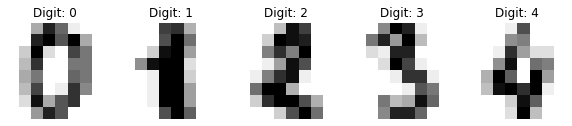

In [16]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Digit: %i" % label)


Digit = 2
[[ 0.  0.  0.  4. 15. 12.  0.  0.]
 [ 0.  0.  3. 16. 15. 14.  0.  0.]
 [ 0.  0.  8. 13.  8. 16.  0.  0.]
 [ 0.  0.  1.  6. 15. 11.  0.  0.]
 [ 0.  1.  8. 13. 15.  1.  0.  0.]
 [ 0.  9. 16. 16.  5.  0.  0.  0.]
 [ 0.  3. 13. 16. 16. 11.  5.  0.]
 [ 0.  0.  0.  3. 11. 16.  9.  0.]]
one-hot encoding
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


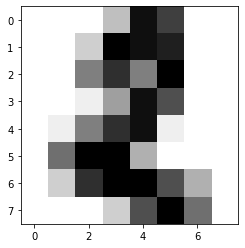

In [17]:
i = np.random.randint(len(digits))
x = digits.images[i]
label = digits.target[i]
print(f'Digit = %s'%label)
print(x)
z = np.zeros(10) # 10 total number of digits
z[label]=1
print('one-hot encoding')
print(z)

ax = plt.subplot()
ax.imshow(x, cmap=plt.cm.gray_r, interpolation="nearest")

## Load data into PyTorch
1. Split into train and validation
2. Create a ```Dataset``` class ([link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html))

In [18]:
from sklearn.model_selection import train_test_split
# load the data
# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    digits.images, digits.target, test_size=0.5, shuffle=False
)

In [69]:
import torch

class CustomImageDataset(Dataset):
    def __init__(self, img_all, img_all_labels, flatten=False, one_hot=False,cnn=False):
        self.img_labels = img_all_labels
        self.img_all = img_all
        self.flatten = flatten
        self.one_hot_label = one_hot
        self.cnn = cnn
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_all[idx]
        label = self.img_labels[idx]
        
        if self.one_hot_label:
            label = torch.nn.functional.one_hot(label,num_classes=10)
        if self.flatten:
            image = torch.flatten(image)
        if self.cnn:
            image = image.unsqueeze(0).float()
        return image, label


Images batch shape: torch.Size([12, 8, 8])
Labels batch shape: torch.Size([12, 10])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[ 0.,  0.,  0.,  7., 16., 16.,  7.,  0.],
        [ 0.,  0.,  0., 14., 16., 16.,  4.,  0.],
        [ 0.,  2., 13., 16., 16., 12.,  0.,  0.],
        [ 0.,  7., 16., 16., 16., 12.,  0.,  0.],
        [ 0.,  0.,  0., 10., 16.,  8.,  0.,  0.],
        [ 0.,  0.,  0., 11., 16., 13.,  0.,  0.],
        [ 0.,  0.,  0., 10., 16., 16.,  2.,  0.],
        [ 0.,  0.,  0.,  9., 16., 12.,  2.,  0.]], dtype=torch.float64)


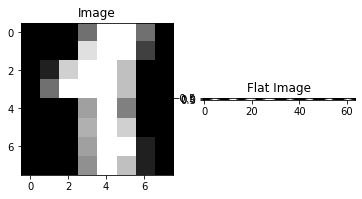

In [27]:
images = torch.tensor(digits.images)
labels = torch.tensor(digits.target)
data = CustomImageDataset(images,labels)

training_data = CustomImageDataset(torch.tensor(X_train),torch.tensor(y_train),False, True)
# test_data = CustomImageDataset(torch.tensor(X_test),torch.tensor(y_test))

train_dataloader = DataLoader(training_data, batch_size=12, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
train_images, train_labels = next(iter(train_dataloader))
print(f"Images batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_labels[0])
print(train_images[0])


_,axs = plt.subplots(1,2)
axs[0].set_title('Image')
axs[0].imshow(train_images[0], cmap="gray")
axs[1].set_title('Flat Image')
axs[1].imshow(torch.flatten(train_images[0]).unsqueeze(0),
              cmap="gray")  # .squeeze(0)
plt.show()


## Softmax

In [28]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(64, 2*64),
        nn.ReLU(),
        nn.Linear(2*64, 2*64),
        nn.ReLU(),
        nn.Linear(2*64, 32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )

  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)


In [22]:
import tqdm

def train(model,training_data,training_epochs=60):
    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  
    trainloader = torch.utils.data.DataLoader(
        training_data, batch_size=12, shuffle=True)
  
    iterator = tqdm.notebook.tqdm(range(training_epochs))
    
    # Run the training loop (epochs)
    loss_trajectory = []
    for epoch in iterator:

        # Set current loss value
        current_loss = []
        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            
            outputs = model(inputs)
            
            optimizer.zero_grad()
            
            loss = loss_function(outputs, targets.float())
            loss.backward()
            optimizer.step()
            
            # Print statistics
            # current_loss += loss.item()
            current_loss.append(loss.item())
        # print('Epoch %s: %.4f +- %.4f'%(epoch,np.array(current_loss).mean(),np.array(current_loss).std()))
        iterator.set_postfix(loss=torch.tensor(current_loss).mean())
        loss_trajectory.append(current_loss)
        # Process is complete.
    return loss_trajectory

Total training data:  (898, 8, 8)


  0%|          | 0/60 [00:00<?, ?it/s]

[[2.281221389770508, 2.301004648208618, 2.341557264328003, 2.369807243347168, 2.235821008682251, 2.3152177333831787, 2.357126474380493, 2.31654691696167, 2.2344725131988525, 2.229273557662964, 2.4023425579071045, 2.268317937850952, 2.193438768386841, 2.364474296569824, 2.24644136428833, 2.3286170959472656, 2.173900604248047, 2.202444314956665, 2.2521908283233643, 2.3254175186157227, 2.2120163440704346, 2.2768728733062744, 2.2347655296325684, 2.343198299407959, 2.330667734146118, 2.27131986618042, 2.1681318283081055, 2.267026662826538, 2.20450496673584, 2.1944751739501953, 2.2953765392303467, 2.1658992767333984, 2.1963393688201904, 2.2624704837799072, 2.2100675106048584, 2.246765613555908, 2.1229794025421143, 2.142212390899658, 2.1524434089660645, 2.1960947513580322, 2.1176159381866455, 2.14888072013855, 2.2051594257354736, 2.1271941661834717, 2.1530206203460693, 2.151759386062622, 2.1381967067718506, 2.1112210750579834, 2.050732374191284, 2.1583101749420166, 2.168076276779175, 2.070991

Text(0, 0.5, 'Cross Entropy')

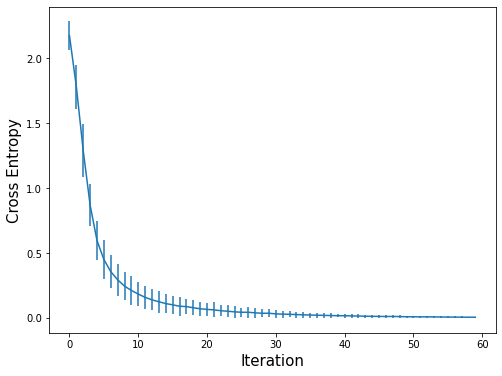

In [36]:
mlp = MLP()
training_data = CustomImageDataset(torch.tensor(
    X_train).float(), torch.tensor(y_train), True, True)


print('Total training data: ', X_train.shape[0])
loss_trajectory = train(mlp,training_data)
print(loss_trajectory)

loss_trajectory = np.array(loss_trajectory)
mean_loss_itr = np.mean(loss_trajectory,axis=1)
std_loss_itr = np.std(loss_trajectory,axis=1)

# figure
plt.figure(figsize=(8,6))
plt.errorbar(np.arange(loss_trajectory.shape[0]),mean_loss_itr,yerr=std_loss_itr)
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Cross Entropy', fontsize=15)

torch.Size([2, 64])
Exact labels:
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
Predicted labels:
tensor([[ -1.6512,  -2.5797,  -7.6714,   0.2035,  -7.2552,  17.7562, -13.0469,
           0.8678,  -3.2384,   6.6439],
        [ -9.4573,  10.5969,  -6.0812,  -2.3882,   3.0760,   0.0965,  -5.6173,
          -1.1437,  -0.3259,  -0.8965]])
Predicted labels (one_hot):
tensor([[3.7277e-09, 1.4731e-09, 9.0560e-12, 2.3821e-08, 1.3730e-11, 9.9999e-01,
         4.1915e-14, 4.6285e-08, 7.6232e-10, 1.4927e-05],
        [1.9511e-09, 9.9939e-01, 5.7085e-08, 2.2928e-06, 5.4134e-04, 2.7508e-05,
         9.0785e-08, 7.9593e-06, 1.8031e-05, 1.0191e-05]])
tensor([5, 1]) tensor([5, 1])


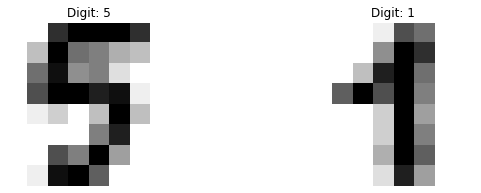

In [37]:
# prediction 
test_data = CustomImageDataset(torch.tensor(
    X_test), torch.tensor(y_test), True, True)

dataloader = DataLoader(training_data, batch_size=2, shuffle=True)

images, labels = next(iter(dataloader))
mlp.eval()
print(images.shape)
pred_labels = mlp(images)
print('Exact labels:')
print(labels.detach())
print('Predicted labels:')
print(pred_labels.detach())
pred_labels_one_hot = pred_labels.softmax(dim=1).detach()
print('Predicted labels (one_hot):')
print(pred_labels_one_hot)
print(torch.argmax(labels, dim=1), torch.argmax(pred_labels_one_hot, dim=1))

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for ax, image, l in zip(axes, images.detach().numpy().reshape((2,8,8)), labels.detach().numpy()):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Digit: %s" % np.argmax(l), )


**What is ```nn.CrossEntropyLoss()```?**\
Cross entropy is used to measure the inefficiency of our predictions used to describe the truth.
$$
H(\mathbf{y},\hat{\mathbf{y}}) = -\sum_i \hat{y}_i\;\log(y_i)
$$
$y$ is the predicted probabilities from our ```model```.
To normalize them, we use the ```SoftMax``` transformation,
$$
y_i = \frac{\exp(\tilde{y}_i)}{\sum_j^{C} \exp(\tilde{y}_j)},
$$
where $\tilde{y}_i$ is the unnormalized probabilities for the class $i$; $\mathbf{\tilde{y}}=[\tilde{y}_0,\cdots,\tilde{y}_{C}]$.

```python
def CrossEntropyLoss(pred,target):
    log_pred = np.log(pred)
    return -np.vdot(target,log_pred)
```

(2500, 2)


Text(0.5, 0, '$z_0$')

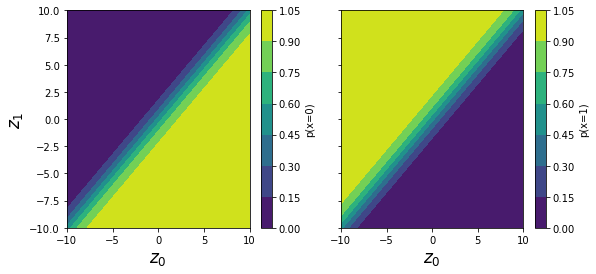

In [41]:
from scipy.special import softmax

z = np.linspace(-10,10)
x_,y_ = np.meshgrid(z,z)
D = np.column_stack((x_.flatten(),y_.flatten()))
print(D.shape)

sftmax = softmax(D,axis=1)

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(9, 4))
cs0 = axs[0].contourf(x_, y_, sftmax[:,0].reshape(x_.shape))
cbar = fig.colorbar(cs0,ax=axs[0],label=f'p(x=0)')
axs[0].set_xlabel(f'$z_0$',fontsize=17)
axs[0].set_ylabel(f'$z_1$',fontsize=17)

cs1 = axs[1].contourf(x_, y_, sftmax[:,1].reshape(x_.shape))
cbar = fig.colorbar(cs1,ax=axs[1],label=f'p(x=1)')
axs[1].set_xlabel(f'$z_0$',fontsize=17)



# Convolutional NeuralNetworks
All images are from the following [link](https://github.com/cs231n/cs231n.github.io/blob/master/convolutional-networks.md)

<img src="https://raw.github.com/cs231n/cs231n.github.io/master/assets/nn1/neural_net2.jpeg" width="500" height="300">
<img src="https://raw.github.com/cs231n/cs231n.github.io/master/assets/cnn/depthcol.jpeg" width="500" height="300">



In [62]:
# code from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 2 * 2, 10) 
        
    def forward(self, x):
        x = self.conv1(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = self.conv2(x)
        # return x
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output   # return x for visualization


torch.Size([2, 10])


  0%|          | 0/60 [00:00<?, ?it/s]

Text(0, 0.5, 'Cross Entropy')

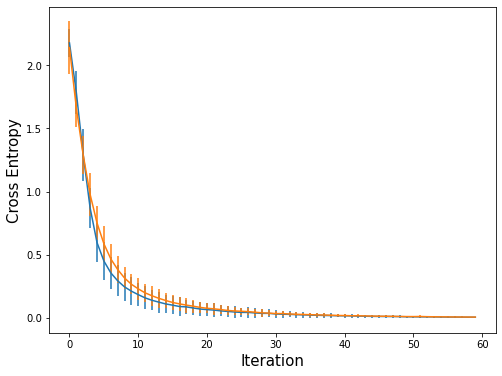

In [73]:
cnn = CNN()
# prediction
training_data = CustomImageDataset(torch.tensor(
    X_train), torch.tensor(y_train), False, True,True)

dataloader = DataLoader(training_data, batch_size=2, shuffle=True)
images, labels = next(iter(dataloader))
mlp.eval()
pred_labels = cnn(images)
print(pred_labels.shape)

loss_trajectory_cnn = train(cnn,training_data)

loss_trajectory_cnn = np.array(loss_trajectory_cnn)
mean_loss_itr_cnn = np.mean(loss_trajectory_cnn, axis=1)
std_loss_itr_cnn = np.std(loss_trajectory_cnn, axis=1)
# figure
plt.figure(figsize=(8, 6))
plt.errorbar(
    np.arange(loss_trajectory.shape[0]), mean_loss_itr, yerr=std_loss_itr, label='MLP')
plt.errorbar(
    np.arange(loss_trajectory_cnn.shape[0]), mean_loss_itr_cnn, yerr=std_loss_itr_cnn, label='CNN')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cross Entropy', fontsize=15)
plt.legend()


The two main ingredients of a **CNN layer** are,
1. Convolution
2. Pooling

**Convolution**
```python
    nn.Conv2d(
        in_channels=1, # Number of channels in the input image
        out_channels=16, # Number of channels produced by the convolution
        kernel_size=5, # Size of the convolving kernel
        stride=1,
        padding=2, # Zero-padding added to both sides of the input
    ),
```
**Pooling**
<img src="https://raw.github.com/cs231n/cs231n.github.io/master/assets/cnn/maxpool.jpeg" width="600" height="300">
